# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

--2025-02-13 16:07:34--  https://www.cs.cmu.edu/~deva/data/aerialseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160128 (88M)
Saving to: ‘/content/aerialseq.npy’

/content/aerialseq. 100%[===================>]  87.89M  1018KB/s    in 67s     

2025-02-13 16:08:41 (1.32 MB/s) - ‘/content/aerialseq.npy’ saved [92160128/92160128]

--2025-02-13 16:08:41--  https://www.cs.cmu.edu/~deva/data/antseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)
Saving to: ‘/content/antseq.npy’

/content/antseq.npy 100%[===================>]  62.50M   830KB/s    in 58s     

2025-02-13 16:09:39 (1.08 MB/s) - ‘/content/antseq.npy’ saved [65536128/65536128]



# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [3]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    p = np.zeros(6)

    # Get image dimensions
    H, W = It.shape
    x = np.arange(W)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()
    Y_flat = Y.flatten()

    # Create a spline
    spline_It = RectBivariateSpline(y, x, It)
    spline_It1 = RectBivariateSpline(y, x, It1)

    for _ in range(num_iters):

        # Warp all template coordinates
        X_warp = (1 + p[0]) * X_flat + p[1] * Y_flat + p[2]
        Y_warp = p[3] * X_flat + (1 + p[4]) * Y_flat + p[5]

        # Determine which warped coordinates lie inside the bound
        mask = (X_warp >= 0) & (X_warp <= (W - 1)) & (Y_warp >= 0) & (Y_warp <= (H - 1))

        # Warped coordinates
        X_valid = X_flat[mask]
        Y_valid = Y_flat[mask]
        X_warp_valid = X_warp[mask]
        Y_warp_valid = Y_warp[mask]

        T_valid = spline_It.ev(Y_valid, X_valid)
        It1_warp = spline_It1.ev(Y_warp_valid, X_warp_valid)

        # error
        error = T_valid - It1_warp

        # Compute image gradients of It1 at the warped positions.
        grad_Ix = spline_It1.ev(Y_warp_valid, X_warp_valid, dx=0, dy=1)
        grad_Iy = spline_It1.ev(Y_warp_valid, X_warp_valid, dx=1, dy=0)

        # build A matrix
        A = np.vstack((
            X_valid * grad_Ix,
            Y_valid * grad_Ix,
            grad_Ix,
            X_valid * grad_Iy,
            Y_valid * grad_Iy,
            grad_Iy
        )).T

        # calcuate dp
        dp,_,_,_ = np.linalg.lstsq(A, error, rcond=None)

        # Update parameters
        p += dp

        # Check converge
        if np.linalg.norm(dp) < threshold:
            break

    # final update M
    M = np.array([[1 + p[0], p[1], p[2]],
                  [p[3], 1 + p[4], p[5]]])

    # ===== End of code =====
    return M

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

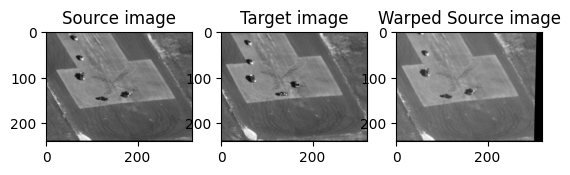

In [4]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [5]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = LucasKanadeAffine(It, It1, threshold, num_iters)

    # wrap it
    warpedIt =  cv2.warpAffine(It, M, (It.shape[1], It.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # Compute absolute difference
    diff = np.abs(It1 - warpedIt)
    mask = diff > tolerance

    mask = binary_erosion(mask)
    mask = binary_dilation(mask)

    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [6]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]

    # ===== your code here! =====
    masks = []

    for i in tqdm(range(N - 1)):
        It = seq[:, :, i]
        It1 = seq[:, :, i + 1]

        # Compute the moving object mask using SubtractDominantMotion
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)

        # Append the mask to the list
        masks.append(mask)
    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [7]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [01:41<00:00,  1.22it/s]


Ant Sequence takes 101.653230 seconds


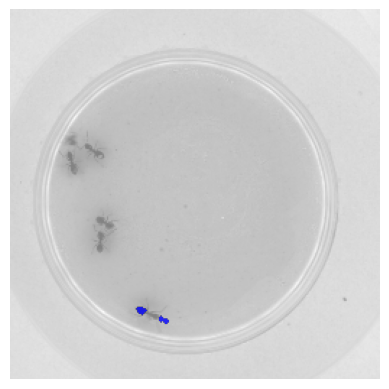

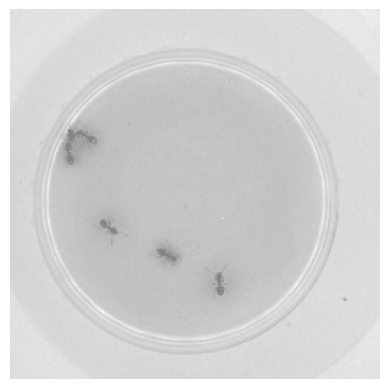

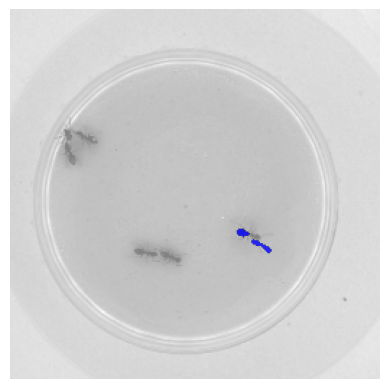

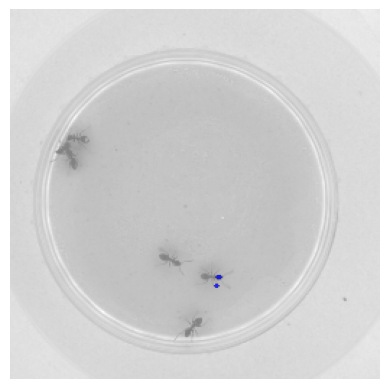

In [8]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]


    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [9]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [03:49<00:00,  1.54s/it]


Ant Sequence takes 229.848679 seconds


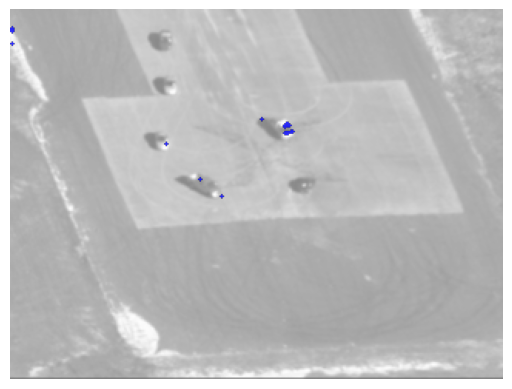

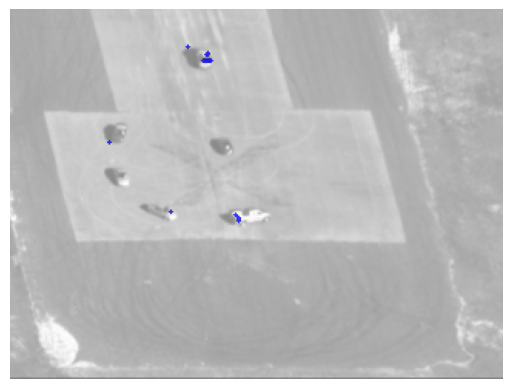

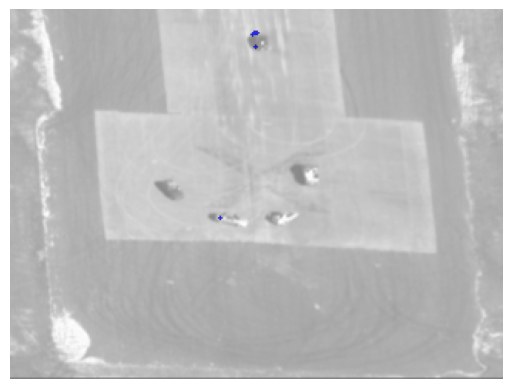

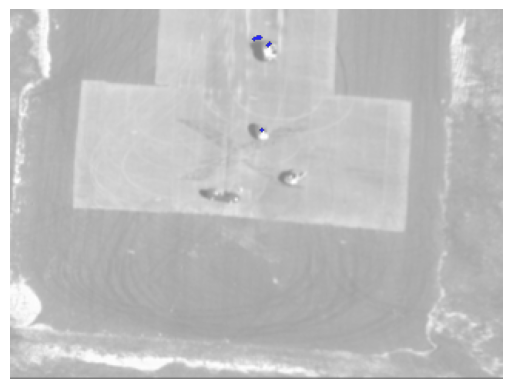

In [10]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')